# Dithering (Difusão do Erro)

"Em 1852 foi patenteado por William Fox Talbot a técnica de impressão conhecida como meio-tom (*halftoning*). A técnica consiste na utilização de pontos, variando o tamanho e espaçamento, gerando um efeito de gradiente e sendo assim capaz de simular tons contínuos. A mesma técnica também é utilizada na impressão colorida, variando a densidade das quatro cores secundárias, ciano, magenta, amarelo e preto (CMYK).

A difusão de erro é um tipo de *halftoning* em que o erro gerado no processo de quantização de uma imagem é distribuído entre os *pixels* vizinhos que ainda não foram quantizados. Floyd e Steinberg (1976) descreveram o um método para difusão de erro baseado no seguinte *kernel* (núcleo)

$
\frac{1}{16} 
        \begin{pmatrix}
          & \ast & 7 \\
        3 & 5 & 1
        \end{pmatrix} 
$

onde $\ast$ denota o *pixel* que está sendo quantizado na etapa corrente do processo de quantização e os demais valores denotam o percentual do erro que será distribuído aos *pixels* vizinhos. Para aplicar o esquema de difusão de erro de Floyd e Steinberg, o processo de quantização transcorre de cima para baixo e da esquerda para a direita. Em cada passo um \emph{pixel} é quantizado e o erro de quantização
é difundido nos *pixels* vizinhos, segundo o *kernel* dado na equação acima.
O erro vai sendo acumulado nos *pixels* que ainda serão quantizados, aumentando assim a probabilidade
deles serem representados por um ponto de representação vizinho àquele que seria representado sem a presença
do erro difundido de seus vizinhos.

Em algumas implementações, a direção de varredura da imagem durante o processo de quantização se alterna entre as linhas. Este tipo de varredura é chamado de varredura em serpentina ou transformação Bustrofédon (O nome Bustrofédon remete a uma escrita arcaica, usando alfabeto grego ou também etrusco, em que o sentido de leitura alternava
entre as linhas, ao invés de manter uma direção fixa como esquerda para direita, como no caso das línguas
europeias, ou direita para esquerda, como no caso do árabe e hebraico. Este tipo de escrita era a forma usual
de se escrever nas pedras na Grécia Antiga.).

No caso de imagens coloridas, o mesmo algoritmo pode ser aplicado a cada uma das componentes de cor (RGB ou CMYK) separadamente. Entretanto, argumenta-se que melhores resultados podem ser obtidos quando é realizada previamente uma conversão dos canais de cores utilizando um modelo perceptivo de cores, separando os canais de luminosidade, matiz e saturação. Desta forma, pondera-se com um peso maior a difusão do erro no canal de luminosidade, uma vez que a visão humana percebe mais facilmente variações em luminosidade do que variações nas componentes de cor."
(Araújo, Sansão e Fasolo, *Quantização Vetorial de Cores em Imagens Digitais*, SBRT 2018)



In [11]:
function Y = floydsteinbergbinary(X)

  if ischar(X), X = imread(X); endif
  if isinteger(X), X = double(X); endif

  Y = X;
  Y = Y./255;
  for i=1:size(Y,1), for j=1:size(Y,2),
    qerr = Y(i,j) - round(Y(i,j));
    Y(i,j) = round(Y(i,j));
    if j<size(Y,2), Y(i,j+1) += qerr*(7/16); endif;
    if i<size(Y,1),
       if j>1, Y(i+1,j-1) += qerr*(3/16); endif;
       Y(i+1,j) += qerr*(5/16);
       if j<size(Y,2), Y(i+1,j+1) += qerr*(1/16); endif;
    endif;
  endfor; endfor;
  Y = Y.*255;

  if nargout < 1,
     figure("position",get(0,"screensize")./[1 1 3 3]);
     subplot(1,2,1); imshow(uint8(X)); title('original');
     subplot(1,2,2); imshow(uint8(Y)); title({'quantized to 1 bit','using dithering (floyd steinberg)'});
  endif
endfunction


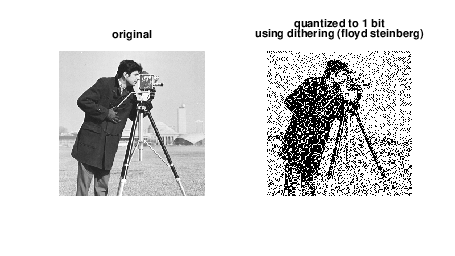

In [12]:
floydsteinbergbinary('imgs/cman.png');

Iremos agora aplicar o dithering em uma quantizador com nbits. Iremos primeiramente definir uma função para criar um quantizador escalar uniforme com nbits.

In [13]:
function [partition, codebook] = uniformquantz(Nbits, Xrange)
  % [partition, codebook] = uniformquantz(Nbits, [Xmin, Xmax])
  % creates a uniform quantizer
  % Nbits : number of bits, #leves = 2^Nbits
  % [Xmin, Xmax] : input signal range  
  Xmin=Xrange(1); Xmax=Xrange(2);
  N = 2^Nbits;
  range = Xmax-Xmin;
  delta = range/N;
  partition = [Xmin+delta : delta : Xmax-delta];
  codebook = [Xmin+delta/2 : delta : Xmax-delta/2];
endfunction

Agora vamos criar a função para aplicar o método de Floyd Steinberg em uma quantização escalar com nbits.

In [31]:
function Xq = floydsteinberg(X,nbits),
  if ischar(X), if exist(X), X = imread(X); else, error('file not found!'); endif; endif
  if isinteger(X), X = double(X); endif
  Y = X;
  Y = Y./255; Yq = [];
  [partition, codebook] = uniformquantz(nbits, [0, 1]);
  for i=1:size(Y,1),
  for j=1:size(Y,2),
      [id, Yq(i,j)] = quantiz(Y(i,j),partition, codebook);
      e = Y(i,j) - Yq(i,j);
      if j < size(Y,2),
         Y(i,j+1)+=(7/16)*e;
      end;
      if i < size(Y,1),
         if j > 1,
            Y(i+1,j-1)+=(3/16)*e;
         elseif j < size(Y,2),
            Y(i+1,j+1)+=(1/16)*e;
         end;
         Y(i+1,j)+=(5/16)*e;
      end; 
  end;
  end;
  Y = Yq.*255;
    if nargout < 1,
     figure("position",get(0,"screensize")./[1 1 3 3]);
     subplot(1,2,1); imshow(uint8(X)); title('original');
     subplot(1,2,2); imshow(uint8(Y)); title({sprintf('quantized to %d bit',nbits),'using dithering (floyd steinberg)'});
  endif
endfunction

E por fim, iremos exercutar um exemplo com a imagem do cameraman.

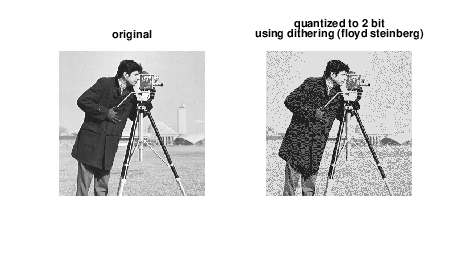

In [32]:
pkg load communications
floydsteinberg('imgs/cman.png',2);